# Dataset Exploration and preprocessing


Directory structure: have a `datasets` directory in the same direction as this file. The `datasets` directory should have the downloaded dataset files from semeval 2020 task 11.

## Load Dataset

In [1]:
import datasets
import seaborn as sns

ds = datasets.load_dataset("sem_eval_2020_task_11", data_dir="./datasets")

In [2]:
ds

DatasetDict({
    train: Dataset({
        features: ['article_id', 'text', 'span_identification', 'technique_classification'],
        num_rows: 371
    })
    test: Dataset({
        features: ['article_id', 'text', 'span_identification', 'technique_classification'],
        num_rows: 90
    })
    validation: Dataset({
        features: ['article_id', 'text', 'span_identification', 'technique_classification'],
        num_rows: 75
    })
})

In [3]:
ds["train"][0]

{'article_id': 'article111111111',
 'text': 'Next plague outbreak in Madagascar could be \'stronger\': WHO\n\nGeneva - The World Health Organisation chief on Wednesday said a deadly plague epidemic appeared to have been brought under control in Madagascar, but warned the next outbreak would likely be stronger.\n\n"The next transmission could be more pronounced or stronger," WHO Director-General Tedros Adhanom Ghebreyesus told reporters in Geneva, insisting that "the issue is serious."\n\nAn outbreak of both bubonic plague, which is spread by infected rats via flea bites, and pneumonic plague, spread person to person, has killed more than 200 people in the Indian Ocean island nation since August.\n\nMadagascar has suffered bubonic plague outbreaks almost every year since 1980, often caused by rats fleeing forest fires.\n\nThe disease tends to make a comeback each hot rainy season, from September to April.\nOn average, between 300 and 600 infections are recorded every year among a popula

## Annotated HTML View


In [4]:
from IPython.display import HTML


def html_view(sample_num: int) -> HTML:
    item = ds["train"][sample_num]
    text = item["text"]
    span_identification = item["span_identification"]
    ret = "<p>"
    for i in range(len(text)):
        if i in span_identification["start_char_offset"]:
            ret += "<span style='background-color: red'>"
        if text[i] == '\n':
            ret += "\\n"
        else:
            ret += text[i]
        if i in span_identification["end_char_offset"]:
            ret += "</span>"
    ret += "</p>"
    return HTML(ret)


html_view(3)

## Labels (probably not needed)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}


<Axes: >

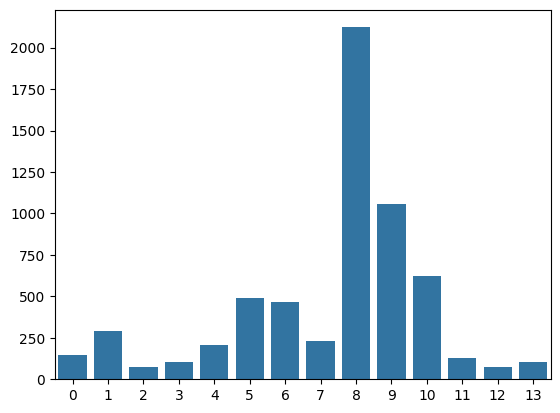

In [5]:
unique_labels = set()
for item in ds['train']:
    unique_labels.update(item['technique_classification']['technique'])
print(unique_labels)

label_counts = {num:0 for num in unique_labels}
for item in ds['train']:
    for technique in item['technique_classification']['technique']:
        label_counts[technique] += 1
sns.barplot(label_counts)


## Span Lengths

<Axes: ylabel='Count'>

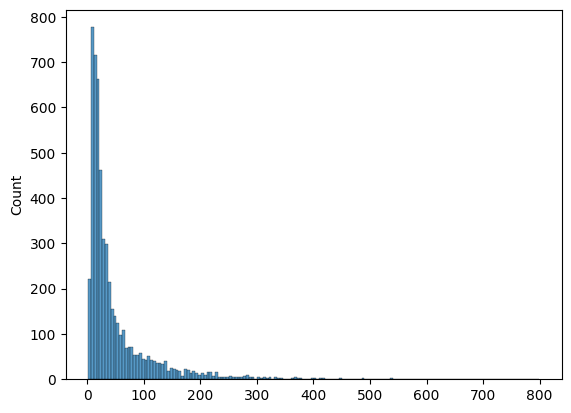

In [6]:
lengths = []
for item in ds['train']:
    lengths.extend(list(map(lambda start, end: end-start, item['span_identification']['start_char_offset'], item['span_identification']['end_char_offset'])))
sns.histplot(lengths)

## Split by sentences

In [7]:
import nltk
from nltk import sent_tokenize
nltk.download("punkt")  # punctuation tokenizer


[nltk_data] Downloading package punkt to /home/eliot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
sentences = []
for idx, instance in enumerate(ds['train']):
    text = instance['text']
    sentences.extend([(item, idx) for item in sent_tokenize(text)])
len(sentences)

14292

In [9]:
newline_sentences = []
for sentence in sentences:
    if "\n" in sentence[0]:
        newline_sentences.append(sentence)


In [10]:
newline_sentences[6]

('SPONSORED\n\nRombot, part of a wave of Indonesian Christians who fled their country following deadly riots in 1998, learned of the policy change when he appeared for an Aug. 1 check-in with ICE and was arrested.',
 3)

In [11]:
# about 12 percent of out dataset has newlines in them, which is not what we want. 
# since those 12 percent are likely to be 2+ sentences.
len(newline_sentences)/len(sentences)  

0.1294430450601735

## Properly split into sentences with labels

In [21]:
items = []
for entry in ds['train']:
    text:str = entry['text']
    spans = list(zip(entry['span_identification']['start_char_offset'], entry['span_identification']['end_char_offset']))
    newline_split = text.split("\n")
    
    for line in newline_split:
        # figure out where the line is
        tokenized_line = sent_tokenize(line)
        for tokenized_sentence in tokenized_line:
            assert type(tokenized_sentence) == str
            index = text.index(tokenized_sentence)
            
            is_classified = False
            for i in range(len(tokenized_sentence)):
                for span in spans:
                    if span[0] <= index+i <= span[1]:
                        # mark it as true
                        is_classified = True
                        break
            
            items.append((tokenized_sentence, is_classified))
                

In [23]:
items[8]

('Cases sprang up far earlier than usual and, instead of being confined to the countryside, the disease infiltrated towns.',
 False)

In [24]:
html_view(0)

In [15]:
# total number of examples
len(items)

16691

In [25]:
# sanity check
for sentence, label in items:
    assert type(sentence) == str

In [28]:
# sanity check to make sure no empty sentences
for sentence, label in items:
    assert len(sentence) > 0

## Processed Dataset Distribution

<Axes: >

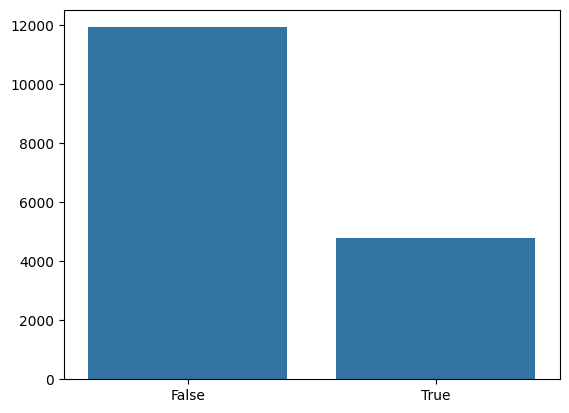

In [30]:
# label distribution
item_distribution = {False:0, True:0}
for sentence, label in items:
    item_distribution[label] += 1
sns.barplot(item_distribution)

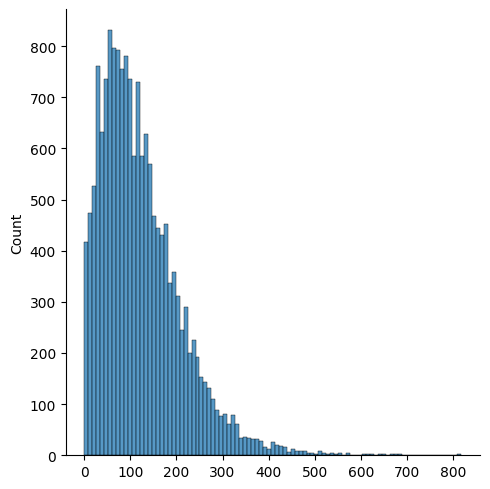

In [31]:
# length distribution
lengths = []
for sentence, _ in items:
    lengths.append(len(sentence))
sns.displot(lengths)

In [32]:
THRESH = 10
check = []
for sentence, _ in items:
    if len(sentence) < THRESH:
        check.append(sentence)

In [33]:
check

['SPONSORED',
 '1',
 '2',
 '3',
 'Perhaps.',
 'The Rev.',
 'Bush.)',
 '.',
 '.',
 'Wait!',
 'Wait!',
 'Give.',
 'Me.',
 'A.',
 'Break.',
 'Like C.S.',
 '!”',
 '[…]',
 '[1]',
 '?',
 '?',
 '–Newsweek',
 '1.',
 '2.',
 '3.',
 '“',
 'and',
 'Really?',
 'Really?',
 'Fr.',
 'Fr.',
 'And mean.',
 'Perjury.',
 'A liar.',
 'Yet Fr.',
 'Fr.',
 'Fr.',
 '248-250).',
 '.',
 '.',
 '* * *',
 '* * *',
 '??Steff??',
 '?',
 '!',
 '?',
 '?',
 '.',
 "'”",
 'Parolin',
 '2:11).',
 '\ufeff',
 'Indeed!',
 '–DOJ',
 '57).',
 'and',
 'Shock!',
 'Fr.',
 'From TPM:',
 'he said.',
 'Paddock."',
 '"No.',
 '.',
 '.',
 'MJM',
 'Why?',
 'Why?',
 'Mgr.',
 'Mgr.',
 'Why?',
 'From God.',
 'Why?',
 'No faith.',
 'Not pope.',
 'Disobey?',
 'Ay.',
 'Very bad.',
 'Montini.',
 'And why?',
 'NOTES:',
 ').',
 'Pic: NASA',
 'No, sins.',
 'Notes:',
 'Related',
 'Why?',
 ').',
 'Finally,',
 '[More]',
 'Why?',
 'No.',
 'and',
 '[...]',
 '[…]',
 '[…]',
 '[1]',
 '[2]',
 '[3]',
 '.',
 '.',
 'No.',
 'Indiana',
 'Oregon',
 'Alabama',
 'Al

In [34]:
len(check)

417